# Image transformations

This notebook introduces a visuall example of the diffrent image transformation that are built inside the lit_eco_classifer package.

## Packages

Prepare the diffrent python packages. 


In [1]:
# Prepare libs
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import os
from PIL import Image
import numpy as np 
import torchvision.transforms as T


In [2]:
# set the working directory to the root of the project
def check_current_work_dir():
    if not os.path.isfile("setup.py") or  os.path.basename(os.getcwd()).endswith('notebooks'):
        print("Changing the current directory to the parent directory containing the setup.py file")

        # move one folder up
        os.chdir("..")
        print(f"New current directory: {os.getcwd()}, it will remain this working directory for the rest of the notebook")

    if not os.path.isfile("setup.py"):
        raise Exception("setup.py not found in the current directory")
    
    if os.path.isfile("setup.py"):
        print("Currently in correct directory")  
check_current_work_dir()


Changing the current directory to the parent directory containing the setup.py file
New current directory: /home/EAWAG/ruizjuan/Repos/plankton_classifier, it will remain this working directory for the rest of the notebook
Currently in correct directory


In [ ]:
# isntall the package
%pip install .

import lit_ecology_classifier.data.image_transformation  as it


## Image Transformations

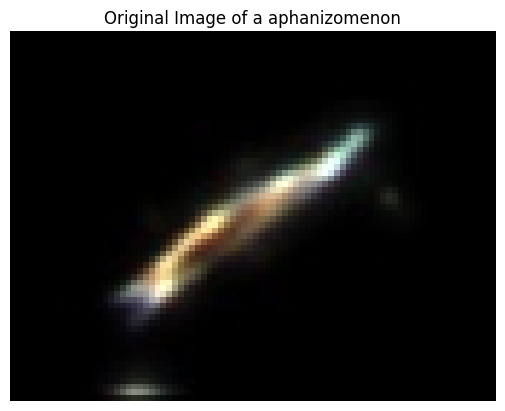

In [4]:
# prepare the image 
file_path = "data/ZooLake2/ZooLake2/ZooLake2.0/aphanizomenon/SPC-EAWAG-0P5X-1570543372901157-3725350526242-001629-055-1224-2176-84-64.jpeg"
image = Image.open(file_path)

#show the original image
plt.imshow(image)
plt.title("Original Image of a aphanizomenon")
plt.axis('off')
plt.show()

### Resizing of the image

The majority of neural entworks requires the image to have a dimension of 224*224 pixel. For a lot of custom dataset, this creates the challenge that the used images need to resized.
THe torchvision.transforms packaes includes a built in fucntion of resizing the images to a defined size, while losing the proportions. To investigate if the change of proportions may influence the behavior of the classifier, a image resizing function that keeps the originals features were buil.


In [5]:
target_size = (224, 224)

# set train flag to false to just resize the image and transform it to a tensor
pipeline_with_porpoptions = it.define_transformation_pipeline(target_size, resize_with_proportions=True, train=False)
pipeline_without_porpoptions = it.define_transformation_pipeline(target_size, resize_with_proportions=False, train=False)

tensor_with_porpoptions = pipeline_with_porpoptions(image)
tensor_without_porpoptions = pipeline_without_porpoptions(image)



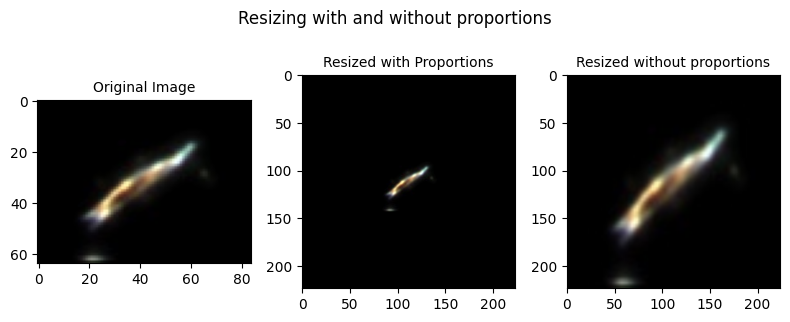

In [6]:

#show the different images
fig, ax = plt.subplots(1, 3, figsize=(8, 5))

ax[0].imshow(image)
ax[0].set_title("Original Image", fontsize = 10)

# change the tensor to numpy array and change the order of the channels
ax[1].imshow(tensor_with_porpoptions.permute(1, 2, 0))
ax[1].set_title("Resized with Proportions", fontsize = 10)


ax[2].imshow(tensor_without_porpoptions.permute(1, 2, 0))
ax[2].set_title("Resized without proportions", fontsize = 10)
plt.suptitle("Resizing with and without proportions", fontsize = 12)


plt.subplots_adjust(right=1.5,top=0.8)
plt.tight_layout(rect=[0, 0.03, 1, 1.3])

plt.show()



### Comparesion with the legacy code

Since the first models of the project were trained with other image transformation methods, we will compare the new transformation methods with the old ones
to ensure that the new methods do not affect the performance of the models and creates the exact same pixel values as the old methods.

In [7]:
# legacy code to proof that the image is not effected by the numpy transformations


# create a hash of the resized image with proportions
tensor_hash= hashlib.sha256(tensor_with_porpoptions.numpy().tobytes()).hexdigest()

# define the transformation pipeline to transform the numpy array to a tensor
trans_NP = T.Compose([
            T.ToPILImage(),
            T.Resize(224),
            T.ToTensor()])
    
resize_transform = it.ResizeWithProportions(target_size)
resized_image = resize_transform(image)


# do the different transformations used in the legacy code
resized_image_np = np.array(resized_image, dtype=np.float32) / 255
resized_image_np = resized_image_np.astype(np.float64) * 255
resized_image_np = resized_image_np.astype(np.uint8)   
tensor_np =  trans_NP(resized_image_np)

tensor_np_hash  = hashlib.sha256(tensor_np.numpy().tobytes()).hexdigest()


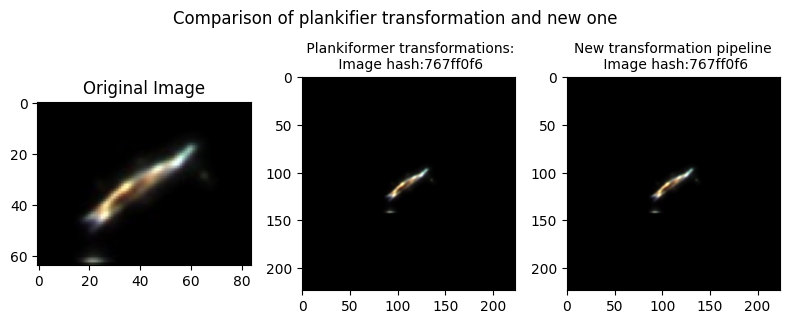

In [8]:

# plot the original and resized image
fig, ax = plt.subplots(1, 3, figsize=(8, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(tensor_np.permute(1, 2, 0))
ax[1].set_title(f" Plankiformer transformations:\n Image hash:{tensor_np_hash[:8]}", fontsize = 10)
ax[2].imshow(tensor_with_porpoptions.permute(1, 2, 0))
ax[2].set_title(f"New transformation pipeline\n Image hash:{tensor_hash[:8]}",fontsize = 10)

plt.suptitle("Comparison of plankifier transformation and new one", fontsize = 12)
plt.tight_layout(rect=[0, 0.03, 1, 1.3])

plt.show()



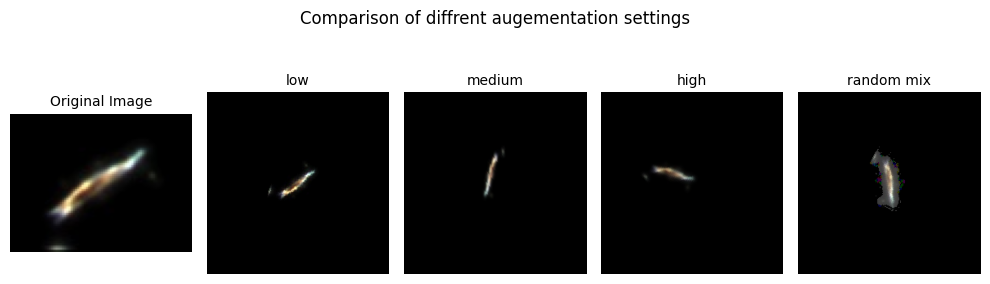

In [ ]:
import torch
image = Image.open(file_path)

torch.manual_seed(1)
# aug_levels
augmentation_levels = ["low", "medium", "high", "random_mix"]


# create a map function to create the different transformations to include the augmentation level and resize with proportions flag
def create_pipelines(augmentation_level, resize_with_proportions, image):
    pipeline = it.define_transformation_pipeline(target_size, resize_with_proportions=resize_with_proportions, train=True, augmentation_level=augmentation_level)
    return pipeline(image)

# create a dictionary with all the transformations
all_augs = {augmentation_level: create_pipelines(augmentation_level, True, image) for augmentation_level in augmentation_levels}


fig, ax = plt.subplots(1, 5, figsize=(10, 5))  

# plot the original image
ax[0].imshow(image)
ax[0].set_title("Original Image", fontsize = 10)
ax[0].axis('off')

for i, (transformation_name, image) in enumerate(all_augs.items(), 1):
    image = image.permute(1, 2, 0)

    ax[i].imshow(image)
    ax[i].set_title(f"{transformation_name.replace('_', ' ')}", fontsize=10)
    ax[i].axis('off')
     
plt.suptitle("Example of diffrent augementation settings", fontsize = 12)
plt.tight_layout(rect=[0, 0.03, 1, 1.3])

plt.show()

